In [4]:
import os
import tensorflow as tf
import keras
import numpy as np
import sys
from task import generate_trials
from models import get_perf
from keras import Model

@tf.function
def do_eval_step(model, trial_x, trial_y, trial_c_mask, trial_y_loc, training_mode):
    """Performs a single evaluation step."""
    y_hat_test = model(
        trial_x, training=False
    )
    loss = model.get_loss(
        y_hat_test,
        trial_y,
        trial_c_mask,
    )
    perf_test = tf.reduce_mean(get_perf(y_hat_test, trial_y_loc))
    accuracy = tf.reduce_mean(
        tf.cast(tf.equal(tf.argmax(y_hat_test, axis=-1), tf.argmax(trial_y, axis=-1)), tf.float32)
    )
    return loss, perf_test, accuracy


def evaluate(model, hp, validation_steps=16):
    for rule_test in hp["rules"]:
        batch_size_test_rep = int(hp["batch_size_test"] / validation_steps)
        loss_tmp = list()
        perf_tmp = list()
        accuracy_tmp = list()
        for i_rep in range(validation_steps):
            trial = generate_trials(
                rule_test, hp, "random", batch_size=batch_size_test_rep
            )

            loss, perf_test, accuracy = do_eval_step(
                model,
                tf.constant(trial.x, dtype=tf.float32),
                tf.constant(trial.y, dtype=tf.float32),
                tf.constant(trial.c_mask, dtype=tf.float32),
                tf.constant(trial.y_loc, dtype=tf.float32),
                False,
            )

            loss_tmp.append(loss.numpy())
            perf_tmp.append(perf_test.numpy())
            accuracy_tmp.append(accuracy.numpy())

        print(
            "{:15s}".format(rule_test)
            + "| cost {:0.6f}".format(np.mean(loss))
            + "  | perf {:0.2f}".format(np.mean(perf_tmp))
            + "  | acc {:0.2f}".format(np.mean(accuracy_tmp))
        )
        sys.stdout.flush()

In [ ]:
def generate_sphere(neurons):
    radius = 2.0

    phi = (np.sqrt(5.) - 1.0) / 2.0

    i = np.arange(neurons)

    z = radius * (1 - 2 * i / (neurons - 1))

    theta = np.arccos(z / radius)

    phi_golden = 2 * np.pi * (i * phi % 1)

    x = radius * np.sin(theta) * np.cos(phi_golden)
    y = radius * np.sin(theta) * np.sin(phi_golden)
    sphere_coords = [x, y, z]
    sphere_coords = tf.constant(sphere_coords, dtype=tf.float32)
    return sphere_coords

In [ ]:
import keras
import numpy as np
import tensorflow as tf
import os
import task
import models
import train_20_task as train_task
import regularizers

network = (7,6,6)
neurons = network[0] * network[1] * network[2]

print(f"Network shape: {network}, Neurons: {neurons}")

original_hp = {
    "n_rnn": neurons,
    "activation": "softplus",
    "loss_type": "softmax",
}

x = np.random.rand(neurons) * network[0]
y = np.random.rand(neurons) * network[1]
z = np.random.rand(neurons) * network[2]

# Combine the coordinates into a single array of shape (3, 245)
rand_coords = [x, y, z]
rand_coords = tf.constant(rand_coords, dtype=tf.float32)

tube_neurons = 252
tube_network = (21,3,4)
tube_hp = {
    "n_rnn": tube_neurons,
    "activation": "softplus",
    "loss_type": "softmax",
}

sphere_coords = generate_sphere(neurons)

dynamic_hp = {
    "n_rnn": neurons,
    "activation": "softplus",
    "loss_type": "softmax",
    "rnn_type": "dynamic",
}


# CHANGE THIS TO YOUR TASK
model_dir = "task20/dynamic_embeddings/repulsion_1"

# model_gen, hp = train_task.init_new_model(model_dir, original_hp)
# model_gen, hp = train_task.init_new_model(model_dir, tube_hp)
model_gen, hp = train_task.init_new_model(model_dir, dynamic_hp)

se = regularizers.SpacialEmbedding(network_structure=network)
# se = regularizers.SpacialEmbedding(coordinates_list=rand_coords)
# se = regularizers.SpacialEmbedding(network_structure=tube_network)
# se = regularizers.SpacialEmbedding(coordinates_list=sphere_coords)

# regu = regularizers.L1(50, se=se)
# regu = regularizers.SE1(90, se=se)
regu = regularizers.SE1_repulsion(90, repulsion_distance=1)



def data_gen(hp, rules = None, probs = None):
    if rules is None:
        rules = hp["rules"]
        probs = hp["rule_probs"]
    elif probs is None:
        probs = [1 / len(rules)] * len(rules)
    while True:
        task_choice = hp["rng"].choice(rules, p=probs)
        trial = task.generate_trials(task_choice, hp, "random", batch_size=hp["batch_size_train"])
        yield trial.x, trial.y

def dataloader_gen(hp, rules=None, probs=None, train=True):
    dataset = tf.data.Dataset.from_generator(
        lambda: data_gen(hp, rules, probs),
        output_signature=(
            tf.TensorSpec(shape=(None, hp["batch_size_train"], hp["n_input"]), dtype=tf.float32),
            tf.TensorSpec(shape=(None, hp["batch_size_train"], hp["n_output"]), dtype=tf.float32),
        ),
    ).prefetch(tf.data.AUTOTUNE)
    return dataset

example_trial = task.generate_trials(hp["rules"][0], hp, "random", batch_size=hp["batch_size_train"])
print("Input shape:", example_trial.x.shape)
print("Output shape:", example_trial.y.shape)
print("Context mask shape:", example_trial.c_mask.shape)

keras.backend.clear_session()  # Clear previous Keras session to avoid clutter
model = model_gen(regu)
y = model(example_trial.x)
print("Model output shape:", y.shape)
loss_fn = keras.losses.MeanSquaredError() if hp["loss_type"] == "mse" else keras.losses.CategoricalCrossentropy(from_logits=False)
loss1 = tf.reduce_mean(loss_fn(example_trial.y, y))
loss2 = model.get_loss(y, example_trial.y, example_trial.c_mask)  # Assuming context mask is not needed for this example
print("Loss1:", loss1.numpy())
print("Loss2:", loss2.numpy())

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=hp["learning_rate"]),
    loss=loss_fn,
    metrics=["accuracy"]
)

checkpoint = tf.train.Checkpoint(optimizer=model.optimizer, model=model)
checkpoint_prefix = os.path.join("data", model_dir, "ckpt")

load_dir = os.path.join("data",model_dir)
checkpoint_name = tf.train.latest_checkpoint(load_dir)
if checkpoint_name:  # Check if checkpoint_name is not None
    checkpoint.restore(checkpoint_name).expect_partial()
    print(f"Model {checkpoint_name} restored from {load_dir}")
    epochs_done = int(checkpoint_name.split("-")[-1])
else:
    print(f"No checkpoint found in {load_dir}. Starting training from scratch.")
    epochs_done = 0

checkpoint_manager = tf.train.CheckpointManager(
    checkpoint, directory=load_dir, max_to_keep=5
)

class CustomModelCheckpoint(keras.callbacks.Callback):
    def __init__(self, checkpoint_manager):
        super().__init__()
        self.checkpoint_manager = checkpoint_manager

    def on_epoch_end(self, epoch, logs=None):
        if self.checkpoint_manager.save():
            pass
        else:
            print("Failed to save checkpoint at epoch", epoch)

try:
    model.fit(
        dataloader_gen(hp, train=True),
        steps_per_epoch=500,
        epochs=100 - epochs_done,
        validation_data=dataloader_gen(hp, train=False),
        validation_steps=16,
        callbacks=[CustomModelCheckpoint(checkpoint_manager)]
    )
except KeyboardInterrupt:
    print("Training interrupted. Saving model...")
    if checkpoint_manager.save():
        print("Checkpoint saved successfully.")
    else:
        print("Failed to save checkpoint.")

Network shape: (7, 6, 6), Neurons: 252
batch_size_train     = 64
batch_size_test      = 512
in_type              = normal
rnn_type             = dynamic
loss_type            = softmax
activation           = softplus
tau                  = 100
dt                   = 20
alpha                = 0.2
sigma_rec            = 0.05
sigma_x              = 0.01
w_rec_init           = randortho
p_weight_train       = None
target_perf          = 1.0
n_eachring           = 16
num_ring             = 2
n_rule               = 20
rule_start           = 33
n_input              = 53
n_output             = 17
n_rnn                = 252
ruleset              = all
save_name            = test
learning_rate        = 0.001
c_intsyn             = 0
ksi_intsyn           = 0
seed                 = 42
rng                  = RandomState(MT19937)
rule_trains          = ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti', 'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm', 'delaydm1', 'delaydm2', 'contex

In [39]:
evaluate(model, hp, validation_steps=16)

fdgo           | cost 0.024514  | perf 1.00  | acc 0.99
reactgo        | cost 0.028778  | perf 1.00  | acc 0.99
delaygo        | cost 0.211906  | perf 0.96  | acc 0.95
fdanti         | cost 0.035487  | perf 1.00  | acc 0.99
reactanti      | cost 0.031816  | perf 1.00  | acc 0.98
delayanti      | cost 0.304553  | perf 0.40  | acc 0.84
dm1            | cost 0.212646  | perf 0.50  | acc 0.86
dm2            | cost 0.193477  | perf 0.53  | acc 0.86
contextdm1     | cost 0.269940  | perf 0.48  | acc 0.86


KeyboardInterrupt: 

In [40]:
import activations
vars = activations.compute_variance(model_dir)
np.save(os.path.join("data", model_dir, "vars.npy"), vars)


Model built successfully with dummy input before restoration.

Model restored from data/task20/dynamic_embeddings/repulsion_1/ckpt-100

--- TF2.x Model Weights: State 3 (After Model Restore) ---
 kernel
  (53, 252) (shape)
 recurrent_kernel
  (252, 252) (shape)
 bias
  (252,) (shape)
 kernel
  (252, 17) (shape)
 bias
  (17,) (shape)
Computing variance for rules: ['fdgo', 'reactgo', 'delaygo', 'fdanti', 'reactanti', 'delayanti', 'dm1', 'dm2', 'contextdm1', 'contextdm2', 'multidm', 'delaydm1', 'delaydm2', 'contextdelaydm1', 'contextdelaydm2', 'multidelaydm', 'dmsgo', 'dmsnogo', 'dmcgo', 'dmcnogo']


In [24]:
import keras
import numpy as np
import tensorflow as tf
import os
import task
import models
from network_custom import Model
import train_task
import regularizers
import modcog_gen
import training

model_dir = "modcog/seRNNs_single_20"

network = (6,6,7)
neurons = network[0] * network[1] * network[2]
print(f"Network shape: {network}, Neurons: {neurons}")
num_batches = 150
batch_size = 64
seq_len = 50
envs = list(modcog_gen.original_envs.values()) 
train = modcog_gen.ModCogDataset(batch_size=batch_size, seq_len=seq_len, num_batches=num_batches, envs=envs)
test = modcog_gen.ModCogDataset(batch_size=batch_size, seq_len=seq_len, num_batches=num_batches//4, train=False, envs=envs)
act_space = train.env.action_space.n
batch = next(iter(train.dataset))
print(batch[0].shape, batch[1].shape)


keras.backend.clear_session()  # Clear previous Keras session to avoid clutter
# model = Model(model_dir, hp)
# regu = regularizers.L1(50, se=regularizers.SpacialEmbedding(network_structure=network))
regu = regularizers.SE1(90, se=regularizers.SpacialEmbedding(network_structure=network))
model = models.KerasModel(neurons=neurons, output_features=act_space, batch_major=True,
                          activation="softplus", loss_type="softmax", recurrent_regulariser=regu)

y = model(batch[0])
print("Model output shape:", y.shape)
loss_fn = keras.losses.SparseCategoricalCrossentropy()
loss1 = tf.reduce_mean(loss_fn(batch[1], y))
print("Loss1:", loss1.numpy())

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss_fn,
    metrics=["accuracy"]
)

checkpoint = tf.train.Checkpoint(optimizer=model.optimizer, model=model)
checkpoint_prefix = os.path.join("data", model_dir, "ckpt")

load_dir = os.path.join("data",model_dir)
checkpoint_name = tf.train.latest_checkpoint(load_dir)
if checkpoint_name:  # Check if checkpoint_name is not None
    checkpoint.restore(checkpoint_name).expect_partial()
    print(f"Model {checkpoint_name} restored from {load_dir}")
else:
    print(f"No checkpoint found in {load_dir}. Starting training from scratch.")

try:
    history = model.fit(
        train.dataset,
        steps_per_epoch=num_batches,
        epochs=80,
        validation_data=test.dataset,
        validation_steps=20,
        callbacks=[regularizers.RNNHistoryI(1)]
    )
except KeyboardInterrupt:
    print("Training interrupted. Saving model...")

print("Training completed. Saving final model...")
training.save_histories(history.history, model_dir)
checkpoint.save(file_prefix=checkpoint_prefix)
print("Final model saved.")

Network shape: (6, 6, 7), Neurons: 252


/Users/huz/.local/share/virtualenvs/dynamically-seRNNs-jOYgDnHA/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.seed to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.seed` for environment variables or `env.get_wrapper_attr('seed')` that will search the reminding wrappers.
  logger.warn(
/Users/huz/.local/share/virtualenvs/dynamically-seRNNs-jOYgDnHA/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.ob to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.ob` for environment variables or `env.get_wrapper_attr('ob')` that will search the reminding wrappers.
  logger.warn(
/Users/huz/.local/share/virtualenvs/dynamically-seRNNs-jOYgDnHA/lib/python3.11/site-packages/gymnasium/core.py:311: UserWarning: WARN: env.gt to get variables from other wrappers is deprecated and will be removed in v1.0

(64, 50, 53) (64, 50)
Model output shape: (64, 50, 17)
Loss1: 1.7769247
No checkpoint found in data/modcog/seRNNs_single_20. Starting training from scratch.
Epoch 1/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 8s 28ms/step - accuracy: 0.8402 - loss: 12.3771 - val_accuracy: 0.8426 - val_loss: 1.3280
Epoch 2/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.8423 - loss: 0.9723 - val_accuracy: 0.8425 - val_loss: 0.6002
Epoch 3/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8460 - loss: 0.5803 - val_accuracy: 0.8529 - val_loss: 0.5535
Epoch 4/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8529 - loss: 0.5450 - val_accuracy: 0.8573 - val_loss: 0.5248
Epoch 5/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8597 - loss: 0.5162 - val_accuracy: 0.8733 - val_loss: 0.4372
Epoch 6/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - accuracy: 0.8718 - loss: 0.4384 - val_accuracy: 0.8812 - val_loss: 0.4057
Epoch 7/80
150/150 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - accuracy: 0.8

In [25]:
import activations
acts = activations.calculate_modcog_activations(model, envs_list=modcog_gen.original_envs, batch_size=batch_size, seq_len=seq_len)
vars = activations.calculate_variances(acts)

np.save(os.path.join("data", model_dir, "modcog_vars.npy"), vars)

Calculating activations for env go


Calculating activations for env rtgo
Calculating activations for env dlygo
Calculating activations for env anti
Calculating activations for env rtanti
Calculating activations for env dlyanti
Calculating activations for env dm1
Calculating activations for env dm2
Calculating activations for env ctxdm1
Calculating activations for env ctxdm2
Calculating activations for env multidm
Calculating activations for env dlydm1
Calculating activations for env dlydm2
Calculating activations for env ctxdlydm1
Calculating activations for env ctxdlydm2
Calculating activations for env multidlydm
Calculating activations for env dms
Calculating activations for env dnms
Calculating activations for env dmc
Calculating activations for env dnmc


Optimal number of clusters: 4
Silhouette scores: [0.30438343, 0.32681572, 0.35202348, 0.3019385, 0.28164288, 0.26888064, 0.27883512, 0.25499678, 0.24895933, 0.2565871, 0.26542422, 0.2703948, 0.26316857, 0.2812562, 0.26008928, 0.27066964, 0.26154703, 0.2823679, 0.2873625, 0.26061502, 0.27893782, 0.2754384, 0.24789196, 0.2459701, 0.26226905, 0.26025057, 0.24439597, 0.24091782]


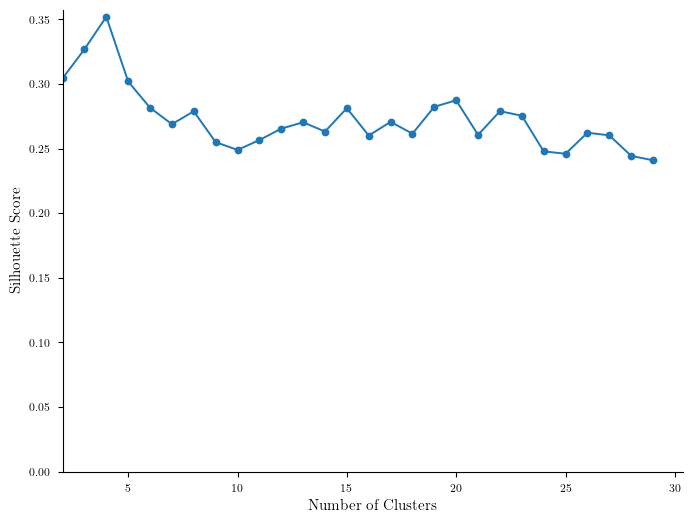

(252,) (20, 252)
TSNE results shape: (252, 2)


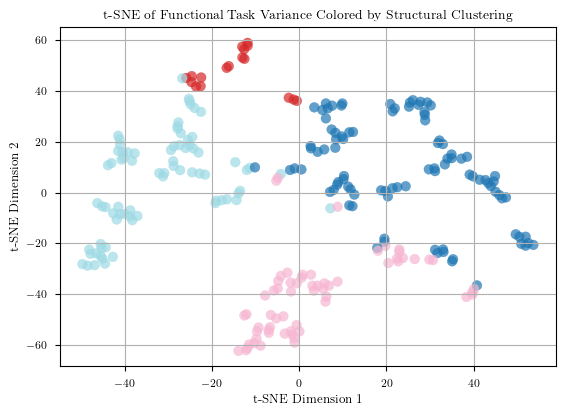

Number of clusters: 4


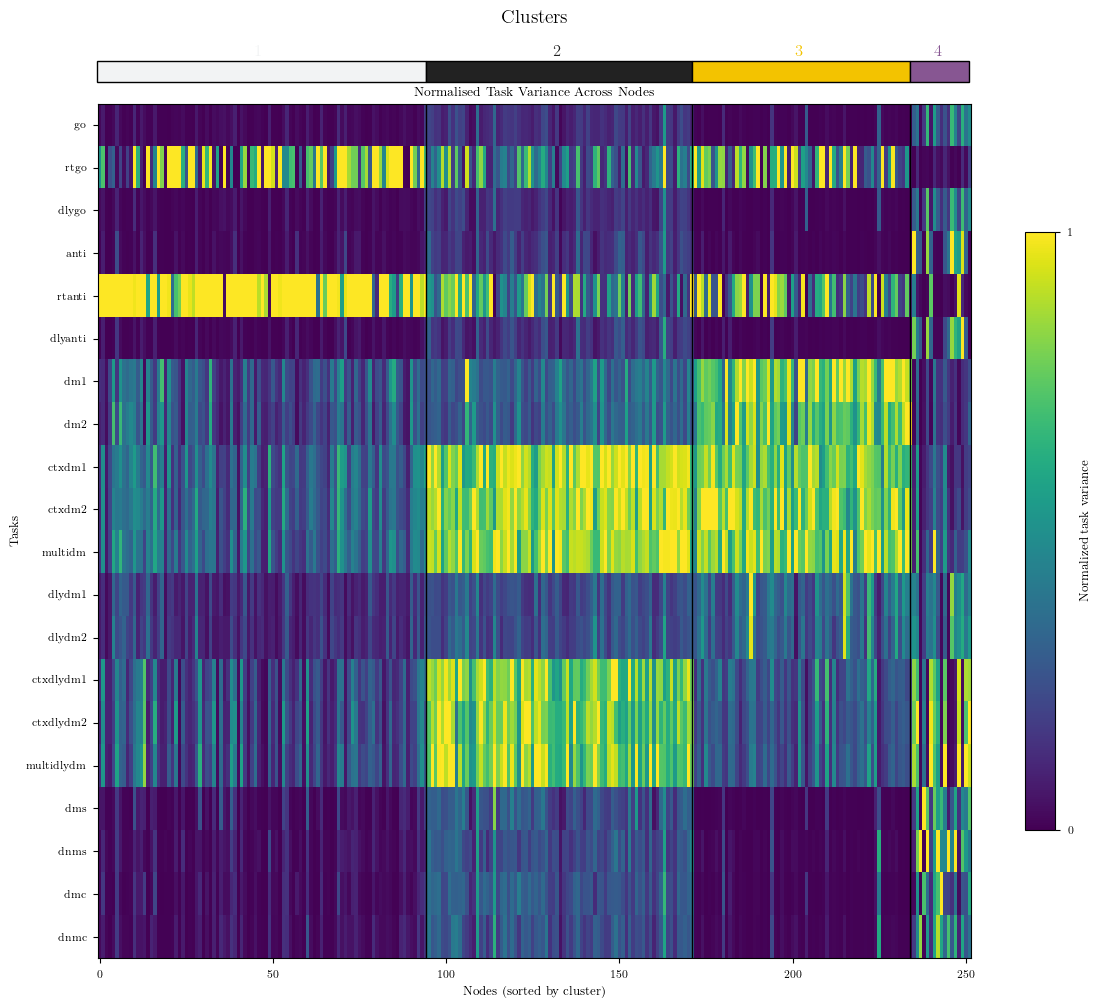

Number of clusters: 10


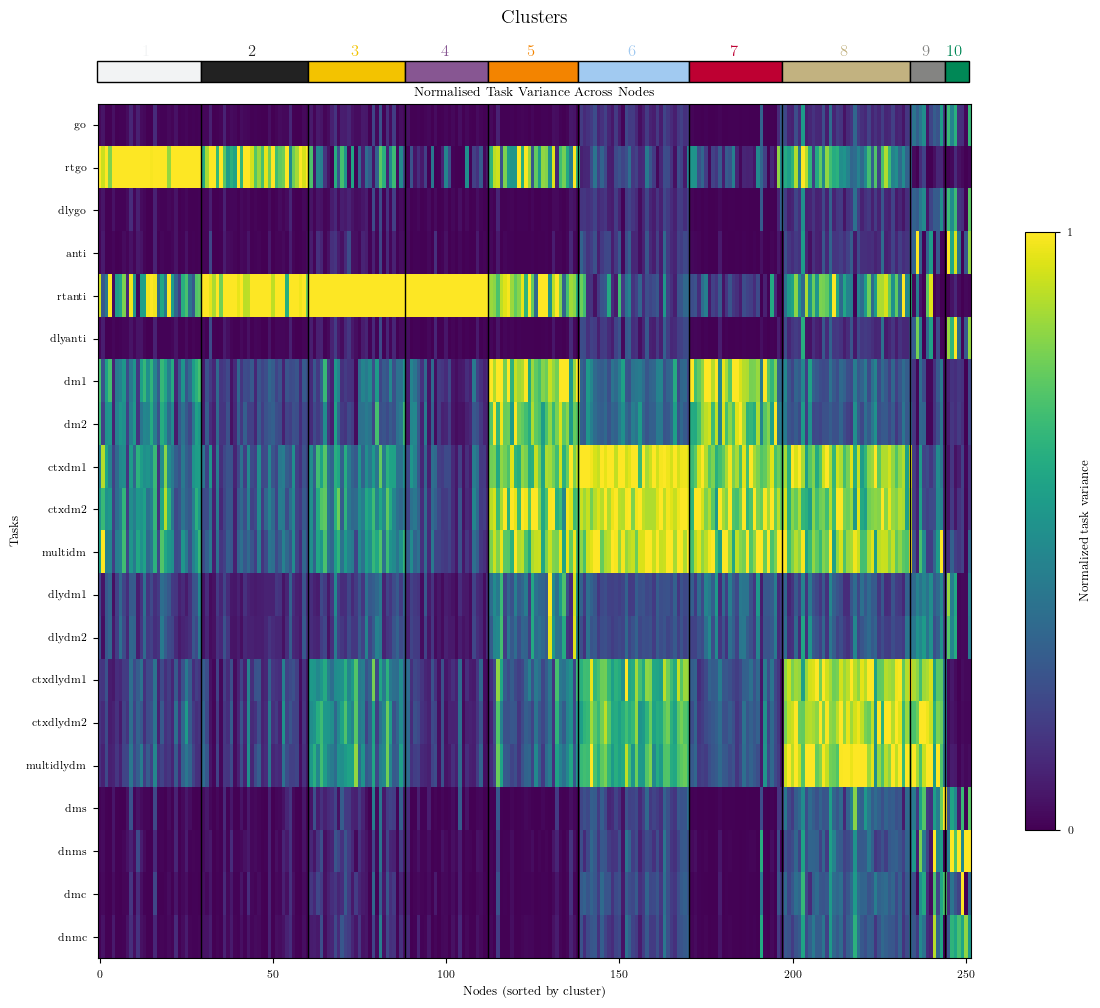

Number of clusters: 11


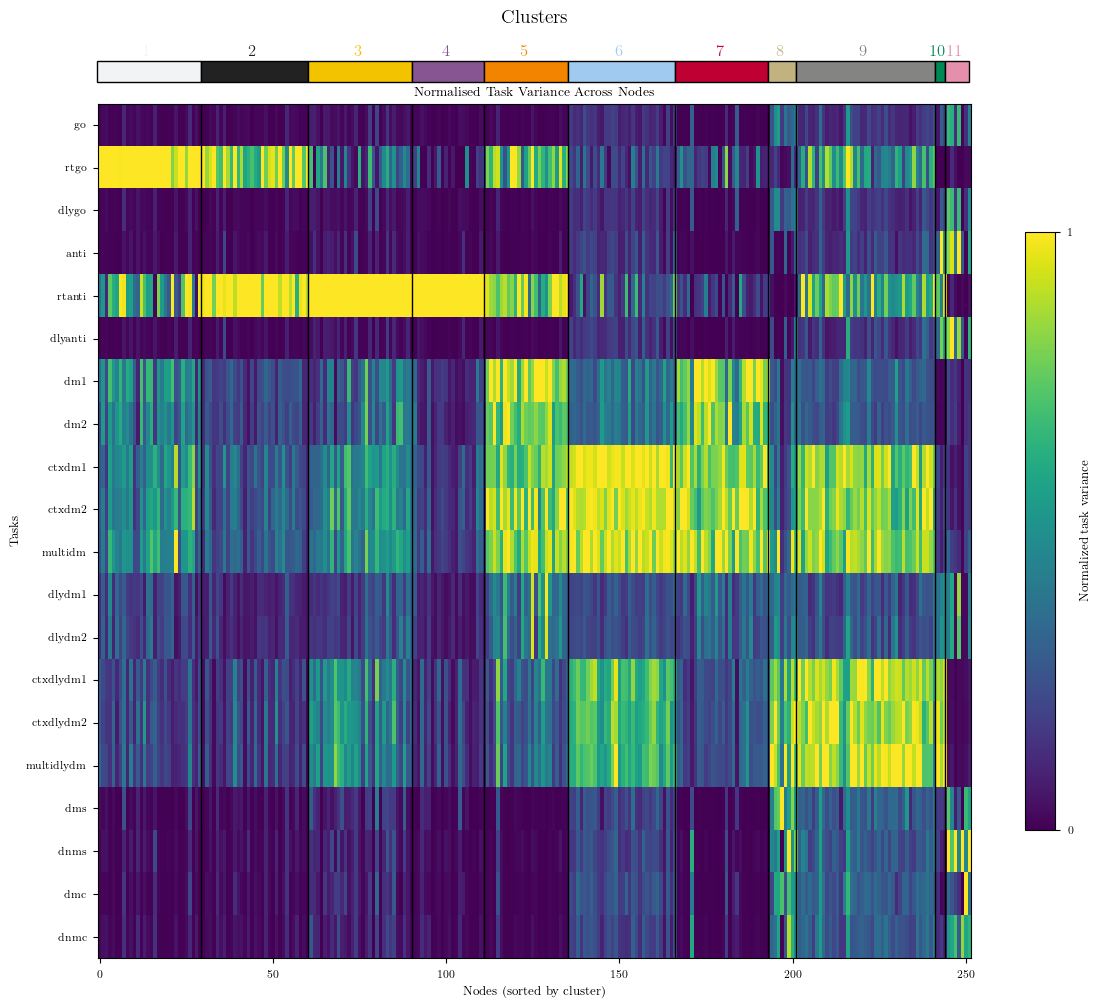

Number of clusters: 12


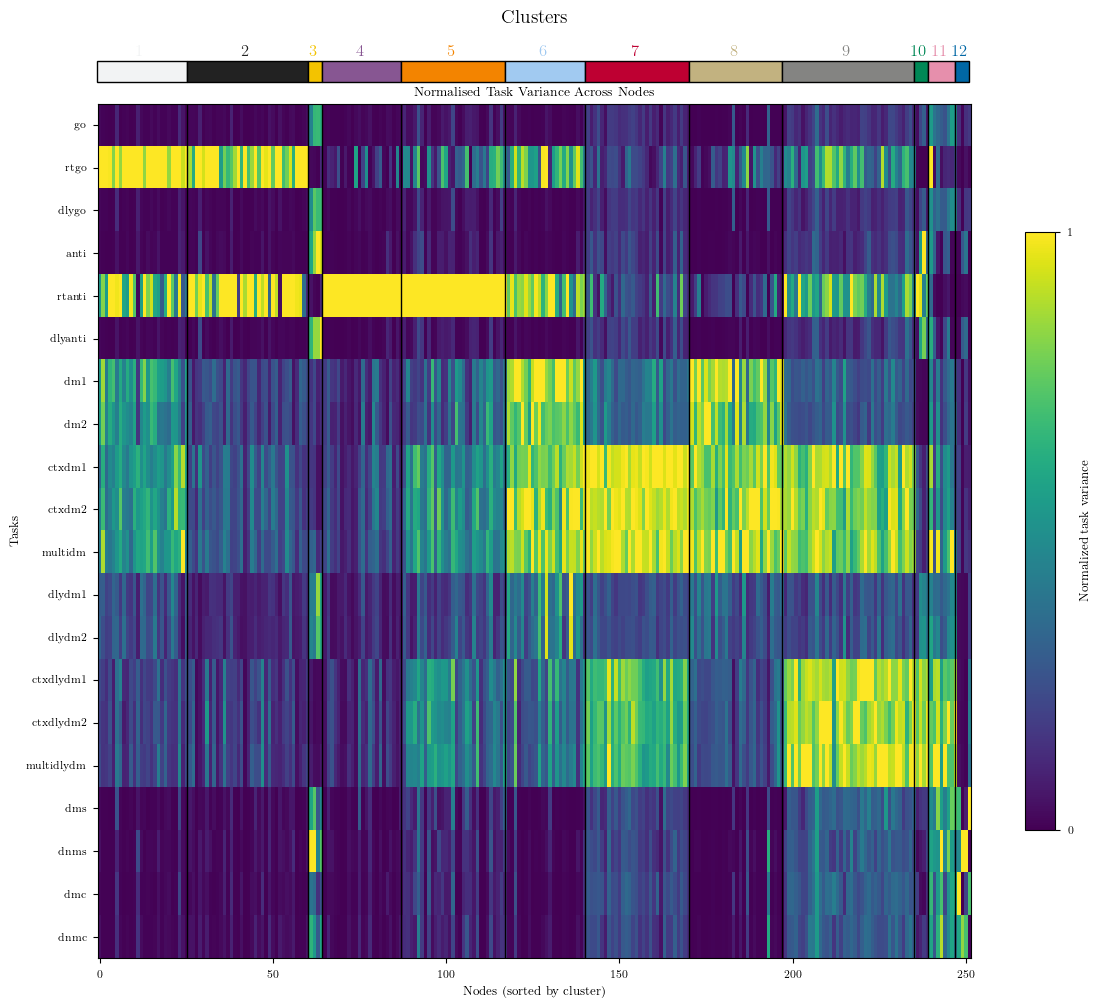

Number of clusters: 13


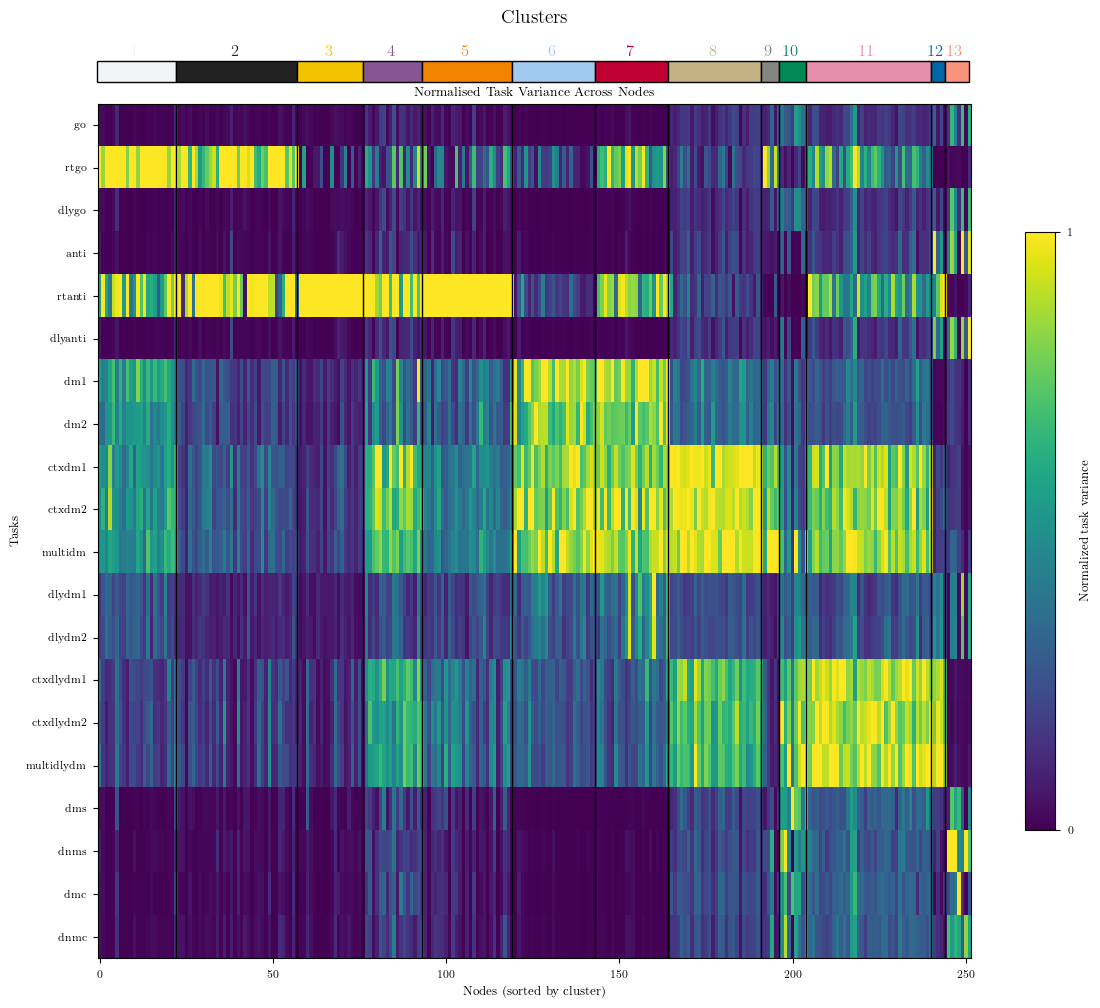

Number of clusters: 14


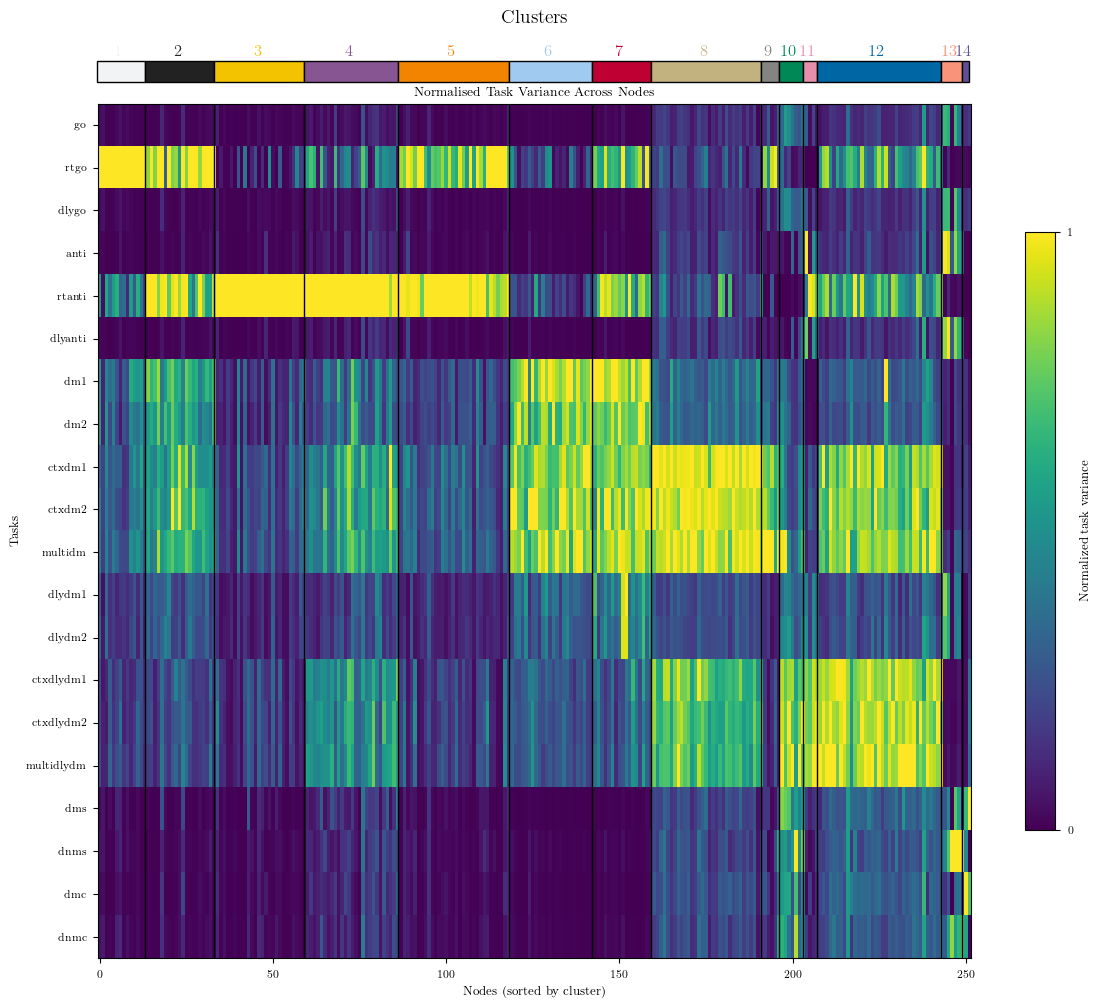

Number of clusters: 15


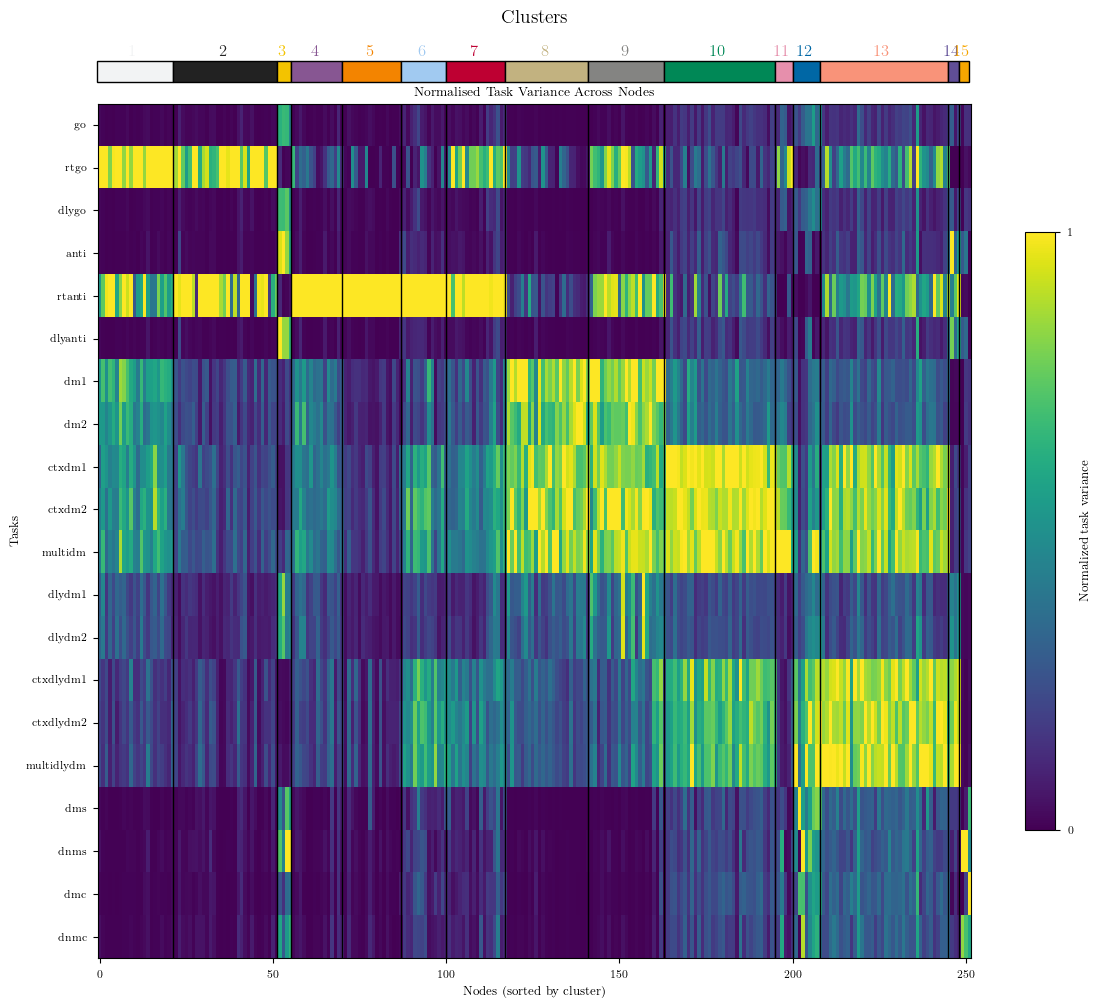

Number of clusters: 16


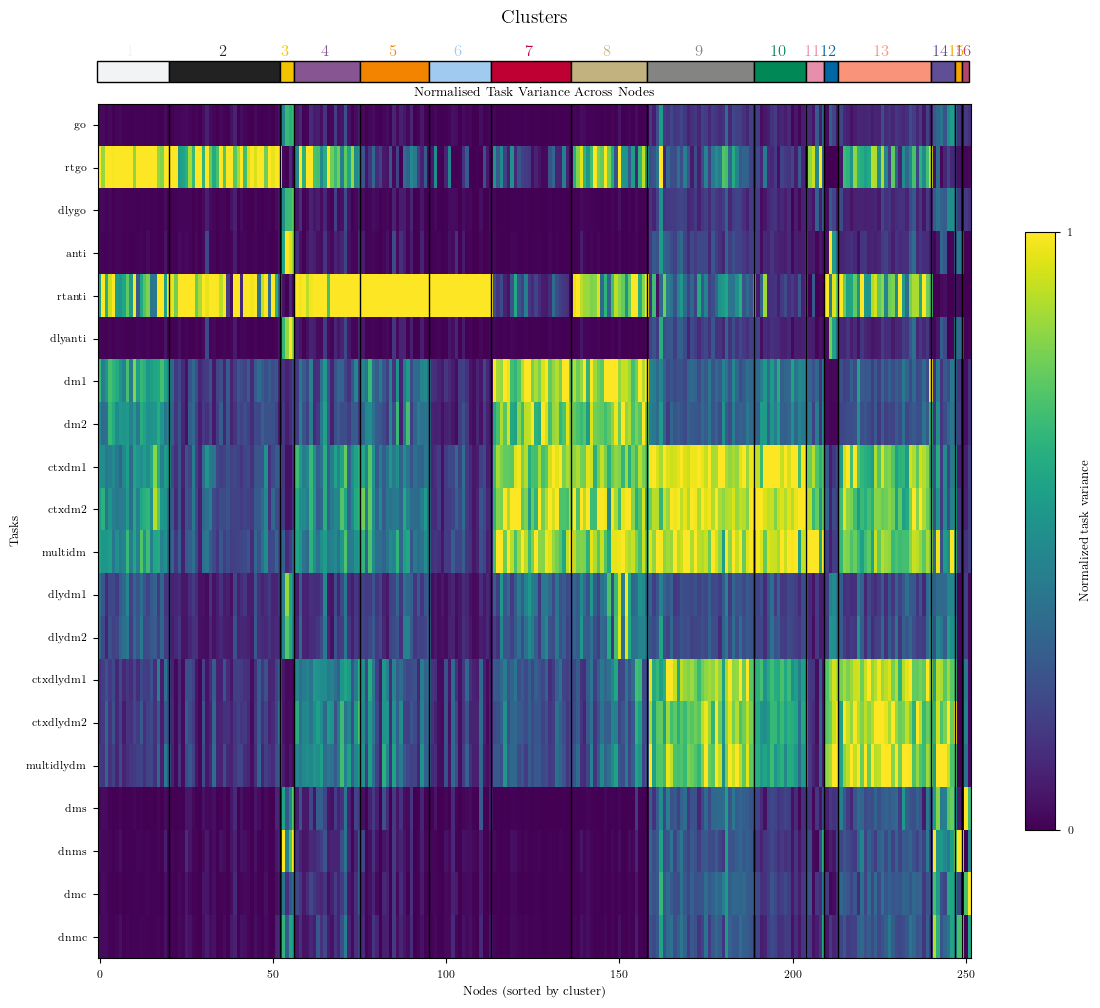

Number of clusters: 17


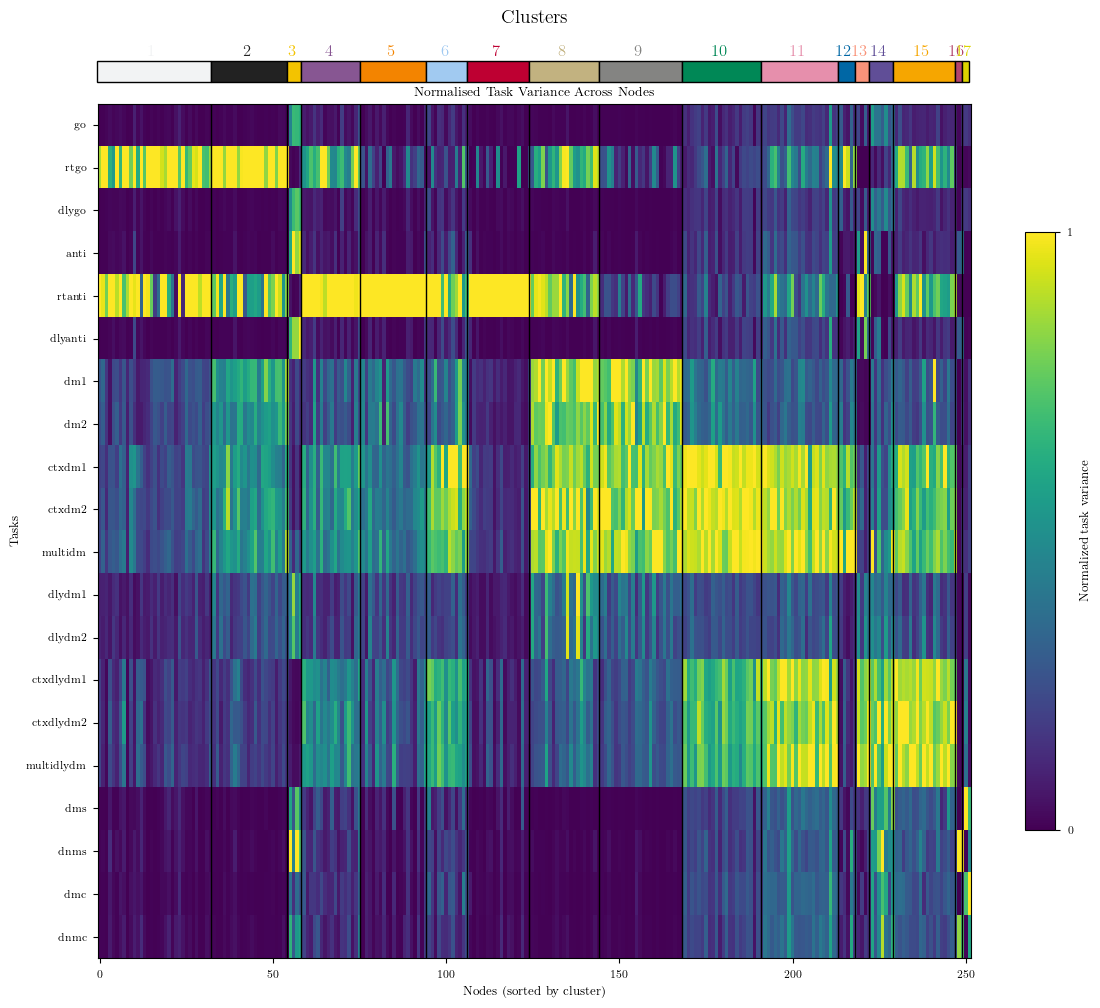

Number of clusters: 18


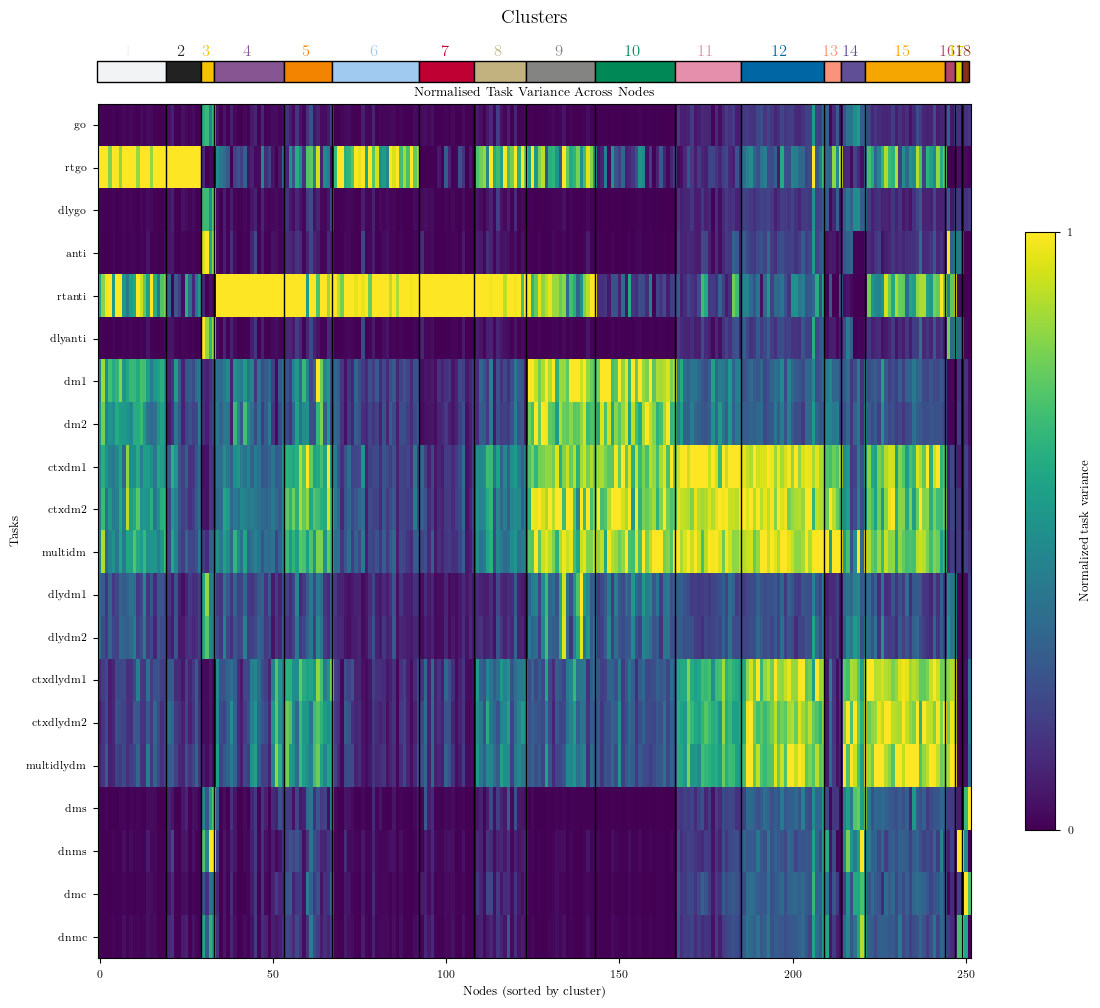

Number of clusters: 19


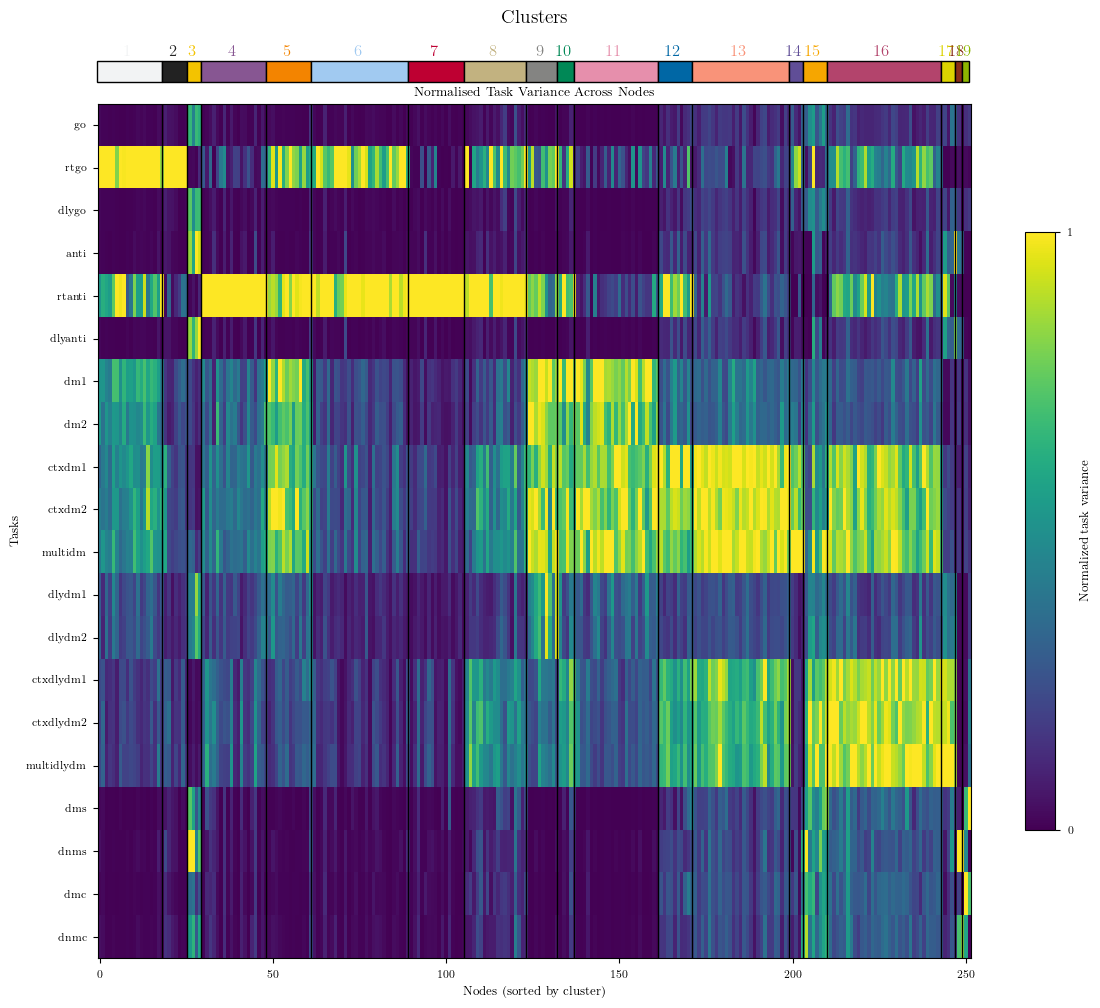

In [ ]:
import numpy as np
import os
vars = np.load(os.path.join("data", model_dir, "modcog_vars.npy"))